In [22]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow 
import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input

# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input

# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input



from keras.models import Model
from keras.utils import to_categorical

In [2]:
token_path = 'C:/Users/abhij/Desktop/minor_proj/Flickr8k_text/Flickr8k.token.txt'
train_images_path ='C:/Users/abhij/Desktop/minor_proj/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'C:/Users/abhij/Desktop/minor_proj/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = 'C:/Users/abhij/Desktop/minor_proj/Flickr8k_Dataset/Flicker8k_Dataset'


doc = open(token_path,'r').read()
print(doc[:410])

icg1 (1).jpg#0	A player is catching a ball.
icg1 (1).jpg#1	Some people are sitting on the chair.	
icg1 (1).jpg#2	A player wearing light sky blue Tshirt catching the ball.	
icg1 (1).jpg#3	There is an advertising board.
icg1 (1).jpg#4	There are white chair beside ground.
icg1 (2).jpg#0	An Indian Player is running for bowling.
icg1 (2).jpg#1	Crowd of people are cheering.
icg1 (2).jpg#2	There is an advertising 


In [3]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0]+" "+tokens[1].split('.')[0]
          image_desc = ' '.join(tokens[2:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

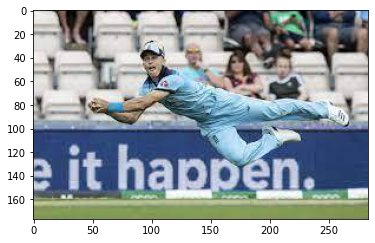

['A player is catching a ball.',
 'Some people are sitting on the chair.',
 'A player wearing light sky blue Tshirt catching the ball.',
 'There is an advertising board.',
 'There are white chair beside ground.']

In [4]:
pic = 'icg1 (1).jpg'
x=plt.imread(images_path+'/'+pic)
plt.imshow(x)
plt.show()
descriptions['icg1 (1)']

In [5]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 466


In [6]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [7]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [8]:
img = glob.glob(images_path + '/*.jpg')
#print(img)
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i.split('\\')[1] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    #print(i.split('/')[5])
    if i.split('\\')[1] in test_images: 
        test_img.append(i)

In [9]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0]+" "+tokens[1].split('.')[0], tokens[2:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)


In [10]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [11]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 54


In [12]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [13]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 16


In [14]:
glove_path = 'C:/Users/abhij/Desktop/minor_proj/glove6b/'

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [15]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
model = DenseNet201(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

In [20]:
def preprocess(image_path):
#   img = tensorflow.keras.utils.load_img(image_path, target_size=(299, 299)) # for inceptionv3
    img = tensorflow.keras.utils.load_img(image_path, target_size=(224, 224)) # for resnet50
    x = tensorflow.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [23]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img] = encode(img)

1/1 [==============================] - 0s 234ms/step


In [24]:
#inputs1 = Input(shape=(4096,))   # for VGG16
inputs1 = Input(shape=(1920,))    # for DenseNet201
#inputs1 = Input(shape=(2048,))   # for InceptionV3 && ResNet50
fe1 = Dropout(0.02)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16, 200)      11000       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1920)         0           ['input_2[0][0]']                
                                                                                            

In [25]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [27]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[images_path + '\\' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [28]:
epochs = 50
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/50
26/26 [==============================] - 8s 101ms/step - loss: 3.3269
Epoch 2/50
26/26 [==============================] - 2s 95ms/step - loss: 2.8297
Epoch 3/50
26/26 [==============================] - 2s 96ms/step - loss: 2.4800
Epoch 4/50
26/26 [==============================] - 2s 83ms/step - loss: 2.1683
Epoch 5/50
26/26 [==============================] - 2s 80ms/step - loss: 1.9299
Epoch 6/50
26/26 [==============================] - 2s 82ms/step - loss: 1.7805
Epoch 7/50
26/26 [==============================] - 2s 86ms/step - loss: 1.7242
Epoch 8/50
26/26 [==============================] - 2s 90ms/step - loss: 1.6511
Epoch 9/50
26/26 [==============================] - 2s 86ms/step - loss: 1.5892
Epoch 10/50
26/26 [==============================] - 2s 81ms/step - loss: 1.5049
Epoch 11/50
26/26 [==============================] - 2s 82ms/step - loss: 1.4124
Epoch 12/50
26/26 [==============================] - 2s 81ms/step - loss: 1.3516
Epoch 13/50
26/26 [=================

In [29]:
 def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [30]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

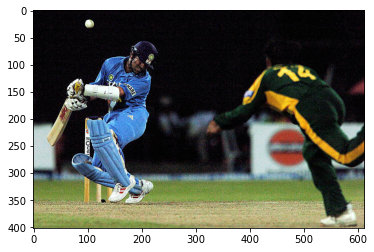

Greedy: A batsman is to
Beam Search, K = 3: A batsman is to
Beam Search, K = 5: A batsman is to
Beam Search, K = 7: A batsman is to


In [31]:
pic = list(encoding_test.keys())[4]
#image = encoding_test[pic].reshape((1,2048))    # for InceptionV3 && ResNet50
image = encoding_test[pic].reshape((1,1920))     # for DenseNet201
#image = encoding_test[pic].reshape((-1,4096))   # for VGG16
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))